##Introduction
The goal is to develop deep learning models for identifying the fruit type in an image (classification) and isolating the fruit region at the pixel level (segmentation). These are essential in applications like automated fruit sorting, quality assessment and in precision agriculture. To achieve this, transfer learning using the ResNet-50 architecture will be used.

## Data

The FruitSeg30 Dataset comprises a collection of 1969 fruit images across 30 distinct fruit classes, with a corresponding segmentation mask. The images was captured in different countries under varied environmental conditions, introducing natural diversity and has also introduced diversity in terms of lighting, viewing angles and background complexity.

 The fruit classes range from common types like apple, banana and mango to more region specific varieties like Burmese Grape, Elephant Apple and Palm. This class diversity, combined with the dataset’s resolution and environmental variety supports our evaluation and training of deep learning models for both fruit classification and segmentation tasks.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path to the unzipped FruitSeg30 dataset
unzip_dir = '/content/drive/MyDrive/assign2_6165/FruitSeg30'

# List the files and directories to confirm
files = os.listdir(unzip_dir)
print(files)

['FruitSeg30']


In [ ]:
import os

# Path to the unzipped dataset
fruitseg_dir = '/content/drive/MyDrive/assign2_6165/FruitSeg30/FruitSeg30'

# Dictionary to store paths to images and masks for each variety
dataset_paths = {
    variety: {
        'images': os.path.join(fruitseg_dir, variety, 'Images'),
        'masks': os.path.join(fruitseg_dir, variety, 'Mask')
    }
    for variety in os.listdir(fruitseg_dir)
    if os.path.isdir(os.path.join(fruitseg_dir, variety)) and
       os.path.exists(os.path.join(fruitseg_dir, variety, 'Images')) and
       os.path.exists(os.path.join(fruitseg_dir, variety, 'Mask'))
}


In [ ]:
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchsummary import summary

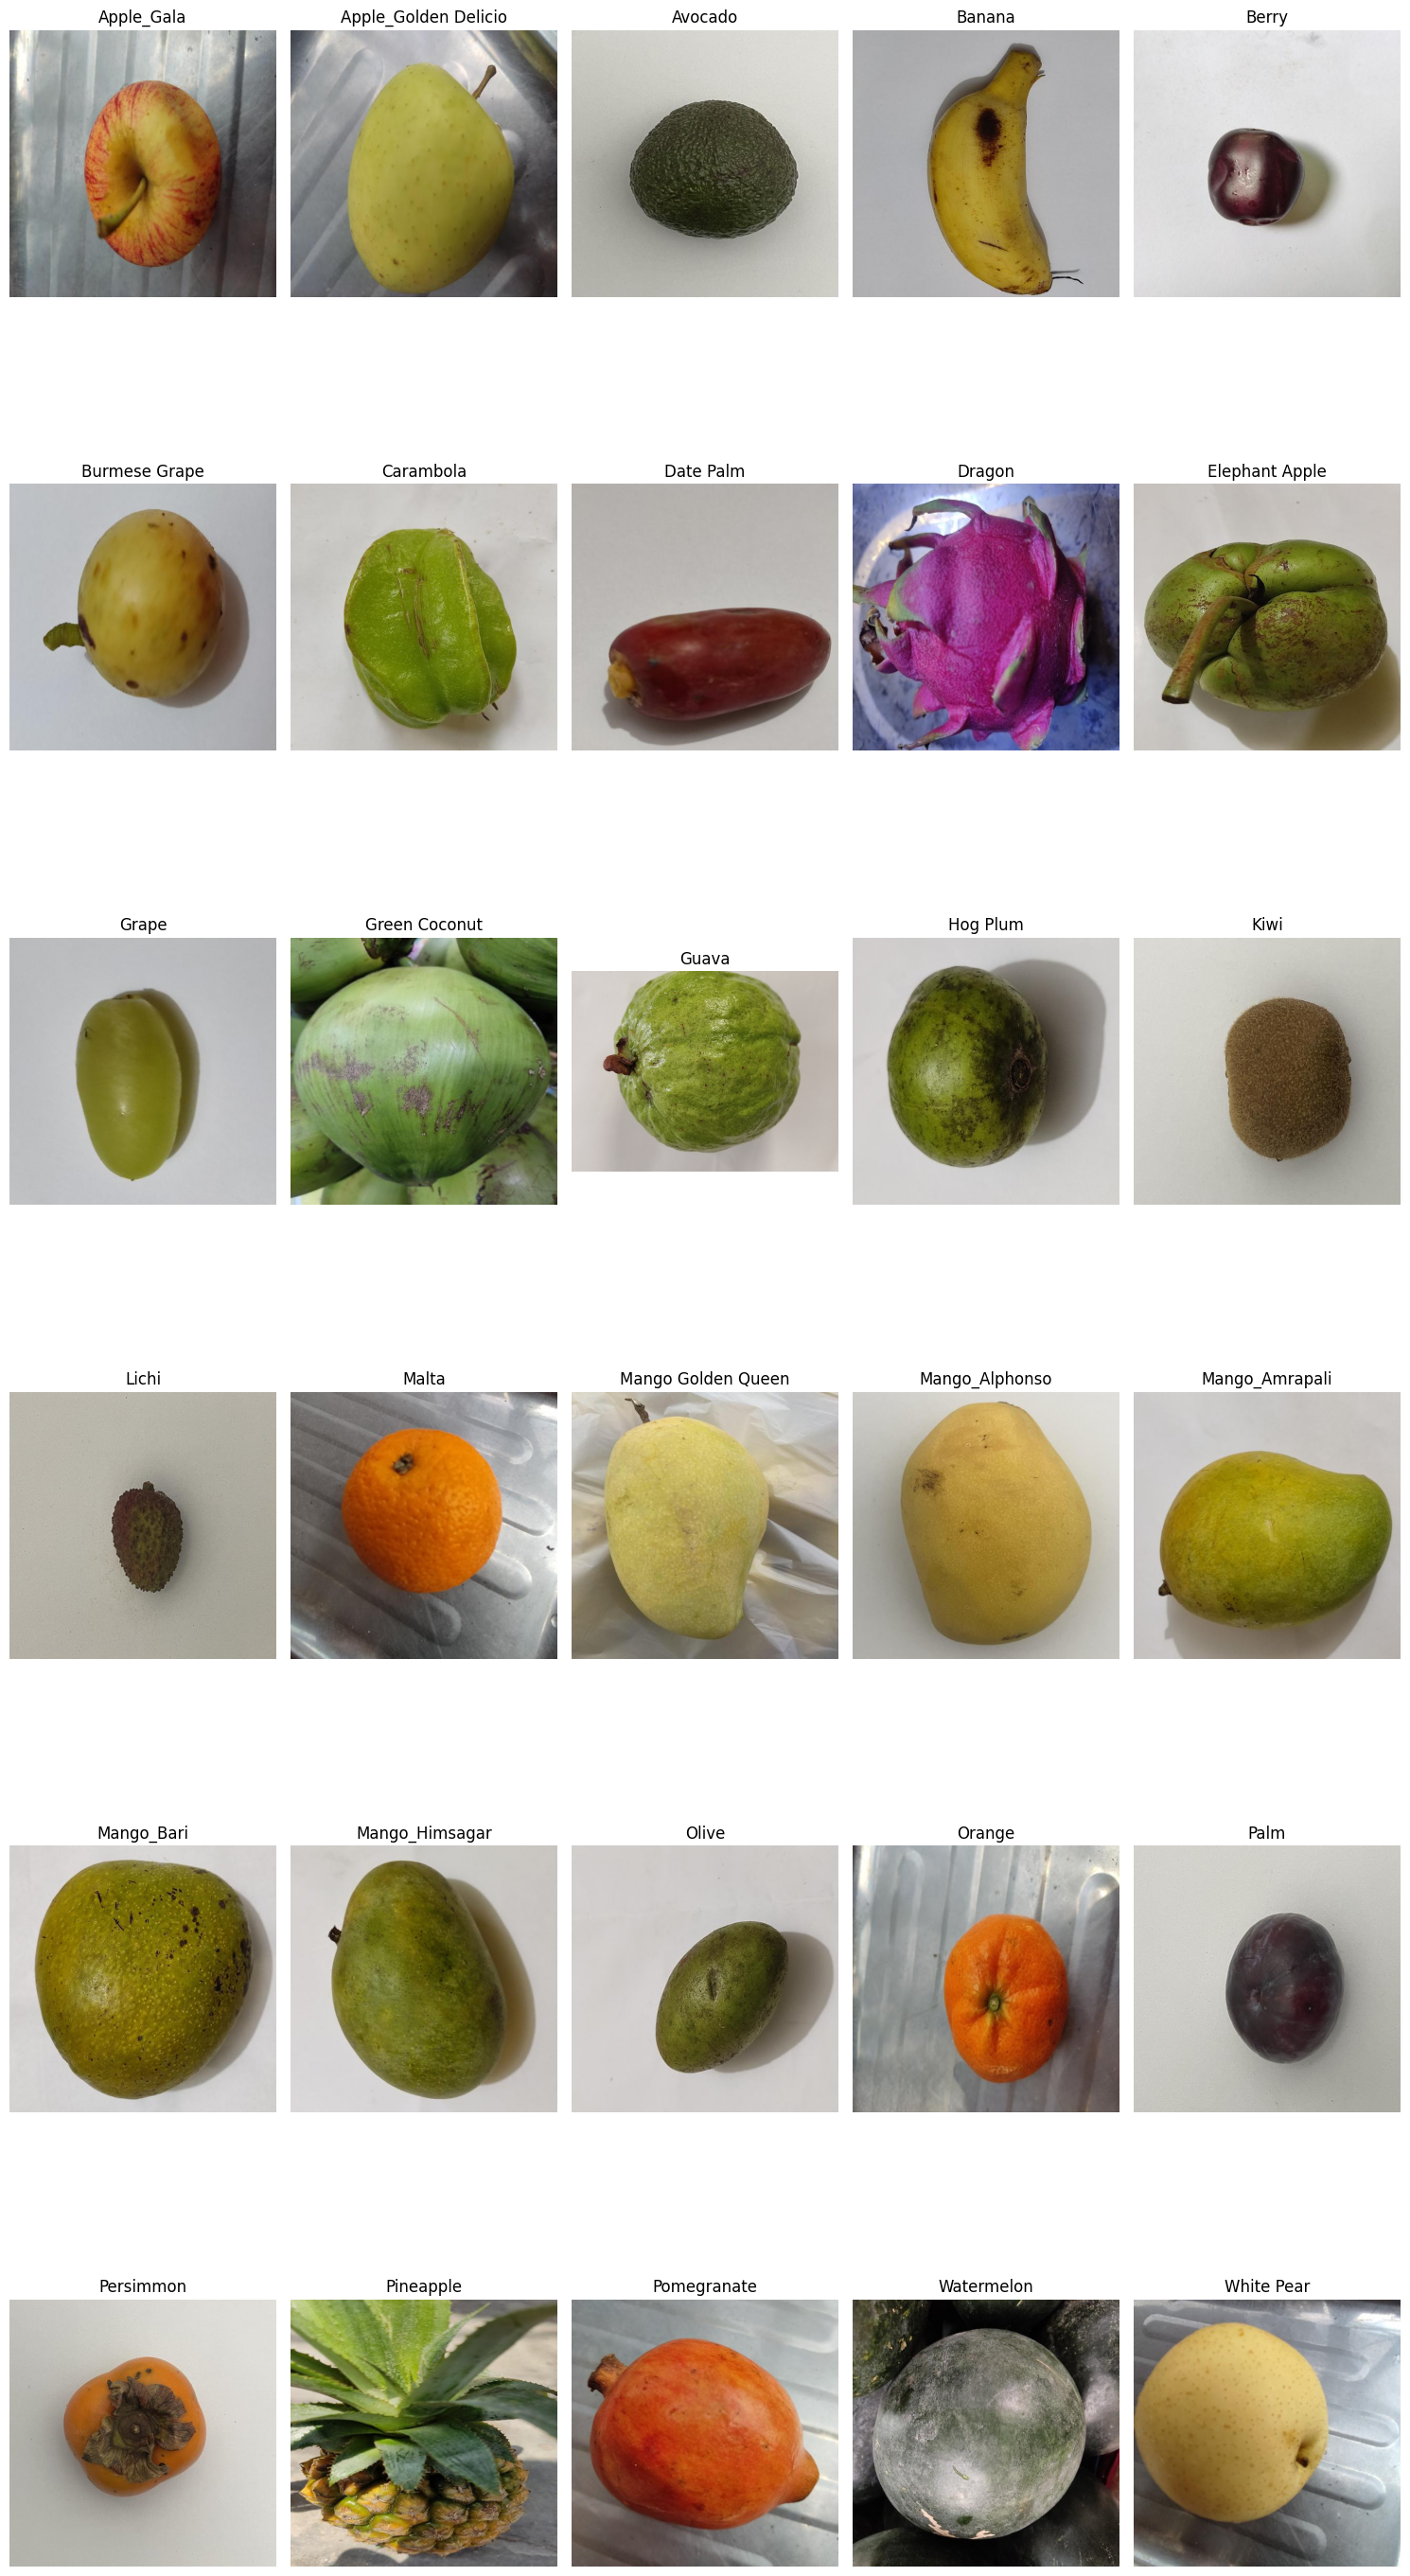

In [ ]:
# List of varieties in the dataset
varieties = os.listdir(fruitseg_dir)[:30]

# Number of images to display per row
images_per_row = 5

num_rows = len(varieties) // images_per_row + (len(varieties) % images_per_row != 0)

# Create a figure to display images
plt.figure(figsize=(15, num_rows * 5))

for i, variety in enumerate(varieties, 1):
    images_dir = os.path.join(fruitseg_dir, variety, 'Images')

    # Get the first image in each variety
    sample_image_name = os.listdir(images_dir)[0]  # Taking the first image to make it simple
    image_path = os.path.join(images_dir, sample_image_name)

    # Open and process the image
    img = Image.open(image_path)
    img_array = np.array(img)

    # Plot image in the corresponding subplot
    plt.subplot(num_rows, images_per_row, i)
    plt.imshow(img)
    plt.title(f"{variety[:20]}")
    plt.axis('off')

# Show the figure
plt.tight_layout()
plt.show()


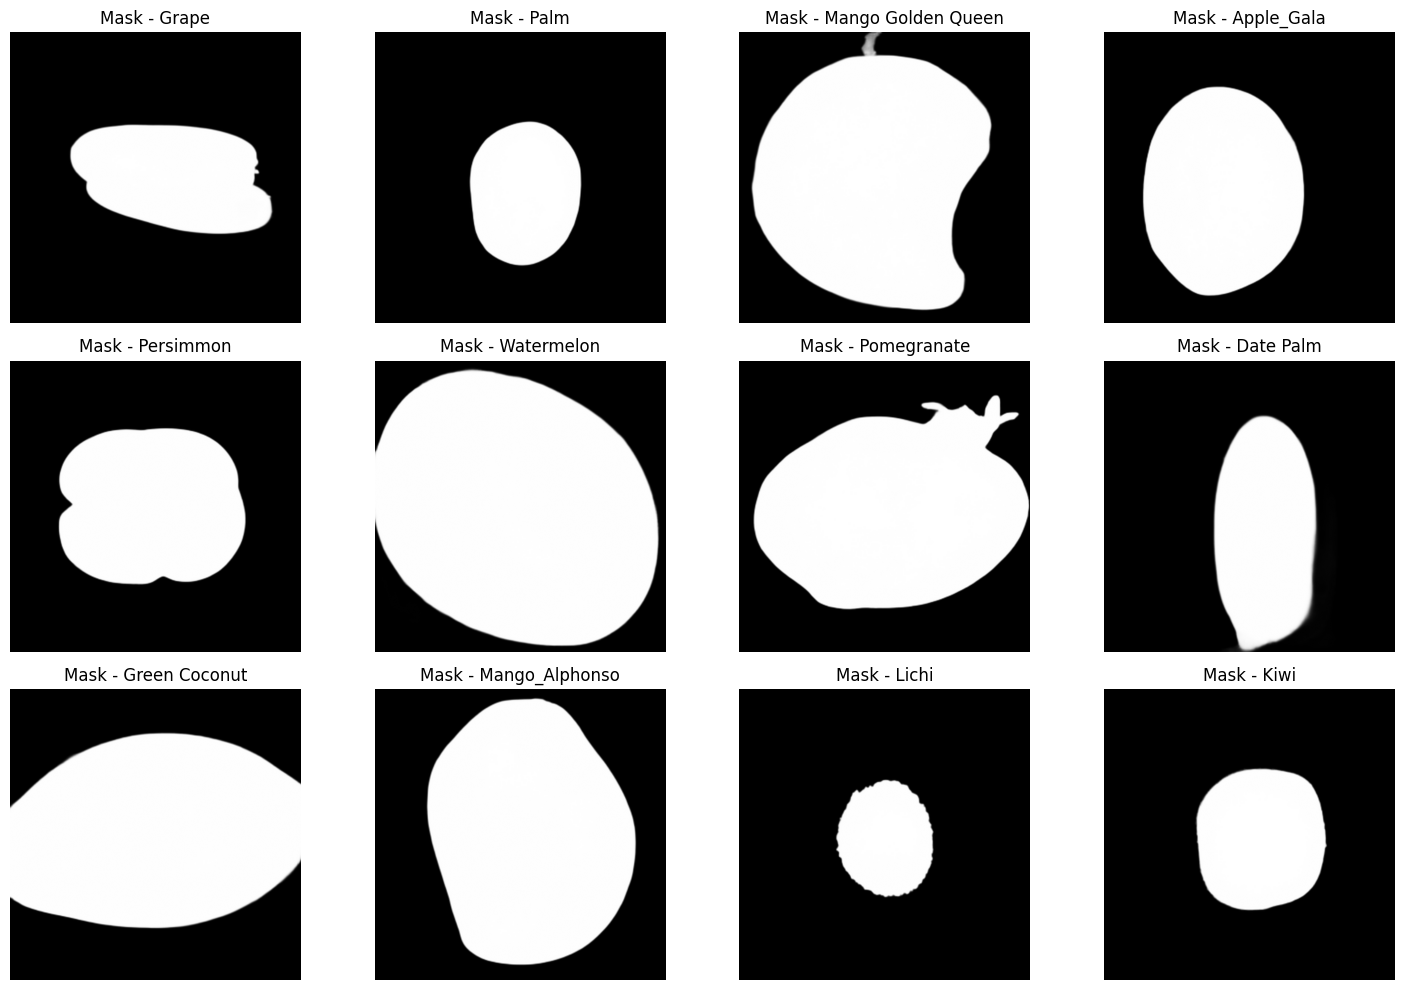

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

# Choose a few random fruit varieties
varieties = random.sample(os.listdir(fruitseg_dir),12)

plt.figure(figsize=(15, 10))

for i, variety in enumerate(varieties):
    mask_dir = os.path.join(fruitseg_dir, variety, 'Mask')
    if not os.path.exists(mask_dir):
        continue

    # Get a random mask from the variety
    masks = [f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg'))]
    if not masks:
        continue

    mask_path = os.path.join(mask_dir, random.choice(masks))
    mask = Image.open(mask_path)

    plt.subplot(3, 4, i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask - {variety[:20]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


##EDA

From our initial visualisation and EDA we could see that each fruit class has a varying number of images and masks, ranging from as few as 16 samples (Mango Golden Queen) to 147 samples (Date Palm). The dataset is imbalanced, with certain fruit varieties such as Carambola, Dragon and Hog Plum being well represented, while others like White Pear, Persimmon, and Mango Golden Queen are relatively small data. Although the dataset is imbalanced, most classes still have a reasonable number of samples (e.g., 40–100 images), which will likely allow the model to learn distinguishing features without severe underfitting. Most of the images in the dataset are of uniform resolution, however, a few outliers were present, for instance, Guava images are notably larger (up to 4000 × 3000). Sample visualizations of the fruit images showed the dataset's good image quality and clear object delineation. Mask showed that fruit regions are typically centered, though there is a significant proportion of background in few images.

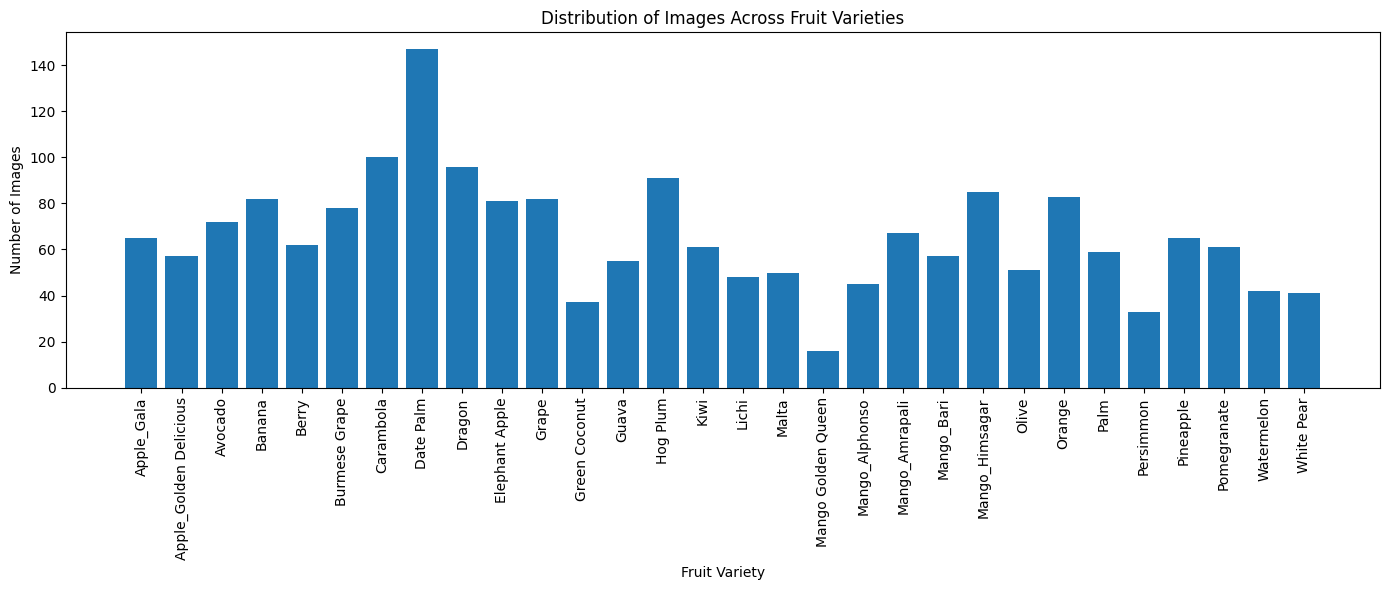

In [ ]:
# Count images in each class
class_counts = {
    variety: len(os.listdir(paths['images']))
    for variety, paths in dataset_paths.items()
}

# Sort by class name or count (optional)
sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))  # alphabetically
# sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))  # by count

# Plot
plt.figure(figsize=(14, 6))
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xticks(rotation=90)
plt.xlabel("Fruit Variety")
plt.ylabel("Number of Images")
plt.title("Distribution of Images Across Fruit Varieties")
plt.tight_layout()
plt.show()


In [ ]:
import os

# List all fruit variety classes (directories under FruitSeg30)
varieties = os.listdir(fruitseg_dir)

# Store image and mask directories for each variety
image_mask_paths = {}

for variety in varieties:
    variety_dir = os.path.join(fruitseg_dir, variety)

    # Only consider directories
    if os.path.isdir(variety_dir):
        images_dir = os.path.join(variety_dir, 'Images')
        masks_dir = os.path.join(variety_dir, 'Mask')

        if os.path.exists(images_dir) and os.path.exists(masks_dir):
            image_mask_paths[variety] = {
                'images': images_dir,
                'masks': masks_dir
            }

# Number of varieties and check image count
print(f"Total varieties: {len(image_mask_paths)}")
for variety, paths in image_mask_paths.items():
    num_images = len(os.listdir(paths['images']))
    num_masks = len(os.listdir(paths['masks']))
    print(f"{variety}: {num_images} images, {num_masks} masks")


Total varieties: 30
Apple_Gala: 65 images, 65 masks
Apple_Golden Delicious: 57 images, 57 masks
Avocado: 72 images, 72 masks
Banana: 82 images, 82 masks
Berry: 62 images, 62 masks
Burmese Grape: 78 images, 78 masks
Carambola: 100 images, 100 masks
Date Palm: 147 images, 147 masks
Dragon: 96 images, 96 masks
Elephant Apple: 81 images, 81 masks
Grape: 82 images, 82 masks
Green Coconut: 37 images, 37 masks
Guava: 55 images, 55 masks
Hog Plum: 91 images, 91 masks
Kiwi: 61 images, 61 masks
Lichi: 48 images, 48 masks
Malta: 50 images, 50 masks
Mango Golden Queen: 16 images, 16 masks
Mango_Alphonso: 45 images, 45 masks
Mango_Amrapali: 67 images, 67 masks
Mango_Bari: 57 images, 57 masks
Mango_Himsagar: 85 images, 85 masks
Olive: 51 images, 51 masks
Orange: 83 images, 83 masks
Palm: 59 images, 59 masks
Persimmon: 33 images, 33 masks
Pineapple: 65 images, 65 masks
Pomegranate: 61 images, 61 masks
Watermelon: 42 images, 42 masks
White Pear: 41 images, 41 masks


In [ ]:
image_sizes = {}

# Get the shape of a few images for each variety
for variety, paths in image_mask_paths.items():
    image_files = os.listdir(paths['images'])
    sizes = []
    for img_name in image_files[:3]:  # Check the first 3 images for each variety
        img = Image.open(os.path.join(paths['images'], img_name))
        sizes.append(img.size)
    image_sizes[variety] = sizes

# Display a few example sizes for each variety
for variety, sizes in image_sizes.items():
    print(f"{variety}: Sizes = {sizes}")


Apple_Gala: Sizes = [(512, 512), (512, 512), (512, 512)]
Apple_Golden Delicious: Sizes = [(512, 512), (512, 512), (512, 512)]
Avocado: Sizes = [(512, 512), (512, 512), (512, 512)]
Banana: Sizes = [(512, 512), (512, 512), (512, 512)]
Berry: Sizes = [(512, 512), (512, 512), (512, 512)]
Burmese Grape: Sizes = [(512, 512), (512, 512), (512, 512)]
Carambola: Sizes = [(512, 512), (512, 512), (512, 512)]
Date Palm: Sizes = [(512, 512), (512, 512), (512, 512)]
Dragon: Sizes = [(512, 512), (512, 512), (512, 512)]
Elephant Apple: Sizes = [(512, 512), (512, 512), (512, 512)]
Grape: Sizes = [(512, 512), (512, 512), (512, 512)]
Green Coconut: Sizes = [(512, 512), (512, 512), (512, 512)]
Guava: Sizes = [(4000, 3000), (4000, 3000), (4000, 3000)]
Hog Plum: Sizes = [(512, 512), (512, 512), (512, 512)]
Kiwi: Sizes = [(512, 512), (512, 512), (512, 512)]
Lichi: Sizes = [(512, 512), (512, 512), (512, 512)]
Malta: Sizes = [(512, 512), (512, 512), (512, 512)]
Mango Golden Queen: Sizes = [(512, 512), (512, 51

## Image Classification (without augumentation)

The core architecture used is ResNet-50, deep convolutional neural network consisting of 50 layers, the network with its use of residual connections (skip connections) help prevent vanishing gradients. These connections allow the network to train effectively.By transfer learning, the model can reuse general features (like edges, shapes, and colors) learned from a large dataset and apply them to our fruit classification task.Transfer learning using IMAGENET1K_V1 pretrained weights is used, this provided a good base for feature extraction.This helped the model:a) Learn faster with fewer epochs. b) Generalize better on our dataset c) Achieve good results. Only the final fully connected (FC) layer of ResNet-50 was modified and trained to output probabilities for the 30 fruit classes, while the rest of the pretrained layers were frozen. The model was trained using the CrossEntropy loss function and experiments were conducted using different optimizers and learning rates.



In [ ]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations (Resize to 224 for better efficiency)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class FruitDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        # Extract the fruit variety as label
        class_name = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
        label = class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, label

# Get all image paths
fruitseg_dir = "/content/drive/MyDrive/assign2_6165/FruitSeg30/FruitSeg30"
fruit_varieties = [v for v in os.listdir(fruitseg_dir) if os.path.isdir(os.path.join(fruitseg_dir, v))]

# Map class names to indices
class_to_idx = {variety: idx for idx, variety in enumerate(fruit_varieties)}

image_paths = []
for variety in fruit_varieties:
    images_dir = os.path.join(fruitseg_dir, variety, "Images")
    for img in os.listdir(images_dir):
        image_paths.append(os.path.join(images_dir, img))


Using device: cuda


In [ ]:
# Split dataset
from sklearn.model_selection import train_test_split
train_images, test_images = train_test_split(image_paths, test_size=0.2, random_state=42)


In [ ]:
# Create datasets & dataloaders (Use num_workers=2 to speed up data loading)
train_dataset = FruitDataset(train_images, transform=image_transform)
test_dataset = FruitDataset(test_images, transform=image_transform)


##Method
The FruitSeg30 dataset contains images organized into folders by fruit variety.Images were resized to 224×224 and normalized using standard ImageNet statistics.Labels were extracted from folder names, and a mapping from class name to index was created.Data was split into 80% training and 20% test sets, with an internal train/val split (80/20) during hyperparameter tuning.

For classification random hyperparameter search was used, this choice was motivated by a combination of computational efficiency and practical effectiveness. While otheres like grid search explores all possible combinations within a defined parameter space, which can become computationally expensive, especially as the number of hyperparameters increases. On the other hand, random search samples combinations at random, offering a faster and more scalable approach that can often find good solutions in fewer iterations.Given the need to run multiple trials across both image classification and segmentation tasks, random search allowed to test a diverse set of learning rates and optimizers. Also, before performing formal hyperparameter search, I manually tested a configuration using Adam optimizer with a learning rate of 0.001 and weight_decay=1e-4. This setup showed promising performance, giving early indication of which parameters worked well for the dataset.

For image classification without augumentation three different optimizers (Adam, AdamW, and SGD ) and three learning rates (1e-4, 5e-4, and 1e-3) were used. The batch size was fixed at 32 for efficiency. Validation accuracy was used to determine the best performing configuration.To manage computational resources effectively,  the number of hyperparameter trials and training epochs were limited during experimentation. The model was trained for 3 epochs during the hyperparameter search, and the best configuration was retrained for 5 epochs on the full training data. This approach allowed for fast iteration while still achieving good performance.

In [ ]:
import random
from itertools import product

# Define search space
lr_options = [1e-4, 5e-4, 1e-3]
optimizers = ['adam', 'sgd', 'adamw']
batch_size = 32  # fixed for efficiency

# Get all combinations and randomly select 4
search_space = list(product(lr_options, optimizers))
random_trials = random.sample(search_space, k=3)


In [ ]:
def get_optimizer(name, model, lr):
    params = model.fc.parameters()
    if name == 'adam':
        return optim.Adam(params, lr=lr)
    elif name == 'sgd':
        return optim.SGD(params, lr=lr, momentum=0.9)
    elif name == 'adamw':
        return optim.AdamW(params, lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {name}")


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    train_acc_history = []
    val_acc_history = []

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f'Training complete in {(time.time() - since) // 60:.0f}m {(time.time() - since) % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, best_acc.item()


In [ ]:
from torch.utils.data import random_split

results = []
num_epochs = 3

for lr, opt_name in random_trials:
    print(f"\n Trying: lr={lr}, optimizer={opt_name}")

    # Create new train/val split
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_sub, val_sub = random_split(train_dataset, [train_size, val_size])

    dataloaders = {
        'train': DataLoader(train_sub, batch_size=batch_size, shuffle=True, num_workers=2),
        'val': DataLoader(val_sub, batch_size=batch_size, shuffle=False, num_workers=2)
    }

    # Load ResNet50 and modify final layer
    model = models.resnet50(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, len(class_to_idx))
    model = model.to(device)

    # Set up optimizer & loss
    optimizer = get_optimizer(opt_name, model, lr)
    criterion = nn.CrossEntropyLoss()

    # Train and store results
    model, train_acc, val_acc, best_val_acc = train_model(model, dataloaders, criterion, optimizer, num_epochs)

    results.append({
        'lr': lr,
        'optimizer': opt_name,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'best_val_acc': best_val_acc
    })



 Trying: lr=0.0005, optimizer=adamw


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.9MB/s]


Epoch 1/3
----------
train Loss: 2.3407 Acc: 0.5389
val Loss: 1.2789 Acc: 0.9048
Epoch 2/3
----------
train Loss: 0.9148 Acc: 0.9262
val Loss: 0.5409 Acc: 0.9587
Epoch 3/3
----------
train Loss: 0.4736 Acc: 0.9754
val Loss: 0.3430 Acc: 0.9683
Training complete in 3m 6s
Best val Acc: 0.9683

 Trying: lr=0.001, optimizer=sgd
Epoch 1/3
----------
train Loss: 2.9897 Acc: 0.2246
val Loss: 2.3813 Acc: 0.6635
Epoch 2/3
----------
train Loss: 2.0096 Acc: 0.7444
val Loss: 1.5206 Acc: 0.8000
Epoch 3/3
----------
train Loss: 1.3469 Acc: 0.8690
val Loss: 1.0315 Acc: 0.9175
Training complete in 0m 28s
Best val Acc: 0.9175

 Trying: lr=0.0001, optimizer=adamw
Epoch 1/3
----------
train Loss: 3.1638 Acc: 0.1611
val Loss: 2.8269 Acc: 0.3778
Epoch 2/3
----------
train Loss: 2.6045 Acc: 0.5270
val Loss: 2.2982 Acc: 0.7048
Epoch 3/3
----------
train Loss: 2.1419 Acc: 0.7706
val Loss: 1.8743 Acc: 0.8127
Training complete in 0m 28s
Best val Acc: 0.8127


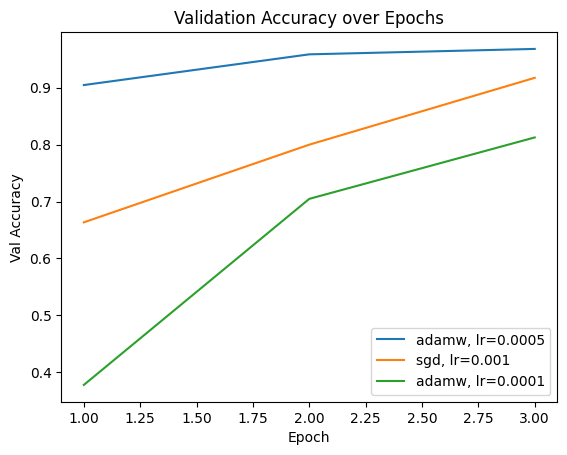


 Best Hyperparameters:
Optimizer: adamw
Learning rate: 0.0005
Best Val Accuracy: 0.9683


In [ ]:
import matplotlib.pyplot as plt

for i, r in enumerate(results):
    label = f"{r['optimizer']}, lr={r['lr']}"
    epochs = range(1, len(r['val_acc']) + 1)
    plt.plot(epochs, r['val_acc'], label=label)

plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend()
plt.show()

# Best result
best = max(results, key=lambda x: x['best_val_acc'])
print("\n Best Hyperparameters:")
print(f"Optimizer: {best['optimizer']}")
print(f"Learning rate: {best['lr']}")
print(f"Best Val Accuracy: {best['best_val_acc']:.4f}")


Epoch 1/5
----------
train Loss: 2.3730 Acc: 0.5571
val Loss: 1.3333 Acc: 0.8476
Epoch 2/5
----------
train Loss: 0.9370 Acc: 0.9317
val Loss: 0.6070 Acc: 0.9714
Epoch 3/5
----------
train Loss: 0.4664 Acc: 0.9794
val Loss: 0.3711 Acc: 0.9810
Epoch 4/5
----------
train Loss: 0.3031 Acc: 0.9849
val Loss: 0.2560 Acc: 0.9810
Epoch 5/5
----------
train Loss: 0.2306 Acc: 0.9889
val Loss: 0.2001 Acc: 0.9873
Training complete in 0m 48s
Best val Acc: 0.9873


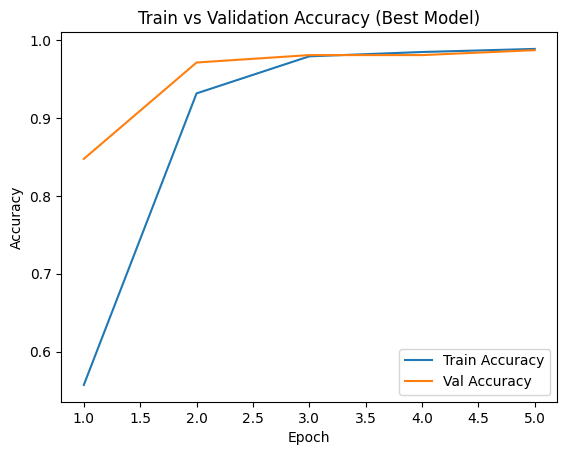

In [ ]:
# block used for curve tracking
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_sub, val_sub = random_split(train_dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_sub, batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(val_sub, batch_size=32, shuffle=False, num_workers=2)
}

# Reload model
model = models.resnet50(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, len(class_to_idx))
model = model.to(device)

# Optimizer & Loss
optimizer = get_optimizer(best['optimizer'], model, best['lr'])
criterion = nn.CrossEntropyLoss()

# Train & track accuracy
model, train_acc, val_acc, _ = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)

# Plot curve
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy (Best Model)")
plt.legend()
plt.show()


In [ ]:
# Recreate dataloader with full training set
final_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Load fresh model
final_model = models.resnet50(weights="IMAGENET1K_V1")
for param in final_model.parameters():
    param.requires_grad = False
final_model.fc = nn.Linear(final_model.fc.in_features, len(class_to_idx))
final_model = final_model.to(device)

# Optimizer and loss (best params)
final_optimizer = get_optimizer(best['optimizer'], final_model, best['lr'])
final_criterion = nn.CrossEntropyLoss()

# Retrain using full training data
final_model, _, _, _ = train_model(
    final_model,
    dataloaders={'train': final_train_loader, 'val': final_train_loader},
    criterion=final_criterion,
    optimizer=final_optimizer,
    num_epochs=5
)


Epoch 1/5
----------
train Loss: 2.1749 Acc: 0.6006
val Loss: 0.9901 Acc: 0.9454
Epoch 2/5
----------
train Loss: 0.7409 Acc: 0.9530
val Loss: 0.3830 Acc: 0.9905
Epoch 3/5
----------
train Loss: 0.3698 Acc: 0.9829
val Loss: 0.2213 Acc: 0.9949
Epoch 4/5
----------
train Loss: 0.2394 Acc: 0.9911
val Loss: 0.1546 Acc: 0.9975
Epoch 5/5
----------
train Loss: 0.1771 Acc: 0.9892
val Loss: 0.1108 Acc: 0.9975
Training complete in 1m 38s
Best val Acc: 0.9975


In [ ]:
# test_loader before evaluation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Evaluate final model on test set
final_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\n Final Test Accuracy: {100 * correct / total:.2f}%")



 Final Test Accuracy: 98.73%


##Evaluation and Results

After identifying the best hyperparameters (adamw,lr=0.0005), the model was retrained on the full training set for five epochs. Evaluation was then carried out on the test set. The model trained without data augmentation achieved good results, reaching a final test accuracy of 98.73%. It showed consistent improvement in both loss and accuracy.The classification report showed perfect or near-perfect precision, recall, and F1-scores across almost all 30 fruit classes. Even slightly lower-performing classes, such as Mango_Amrapali (F1: 0.93), Mango_Bari (F1: 0.90), and Pomegranate (F1: 0.95), still maintained very high accuracy, suggesting that the model generalizes well. The high performance can be attributed in part to the dataset’s clean (objects were almost in the middle for most of the pictures) and good quality images (noise free), which made it easier for the model to learn class distinguishing features. Essentially, the model achieved near perfect accuracy primarily due to:

a) High-quality, clean images in the dataset
b) Strong pretrained features from ImageNet V1
c) Careful fine-tuning and optimization

Despite minor class imbalance, the model generalized well. There were no signs of overfitting and validation accuracy remained consistently high across trials.

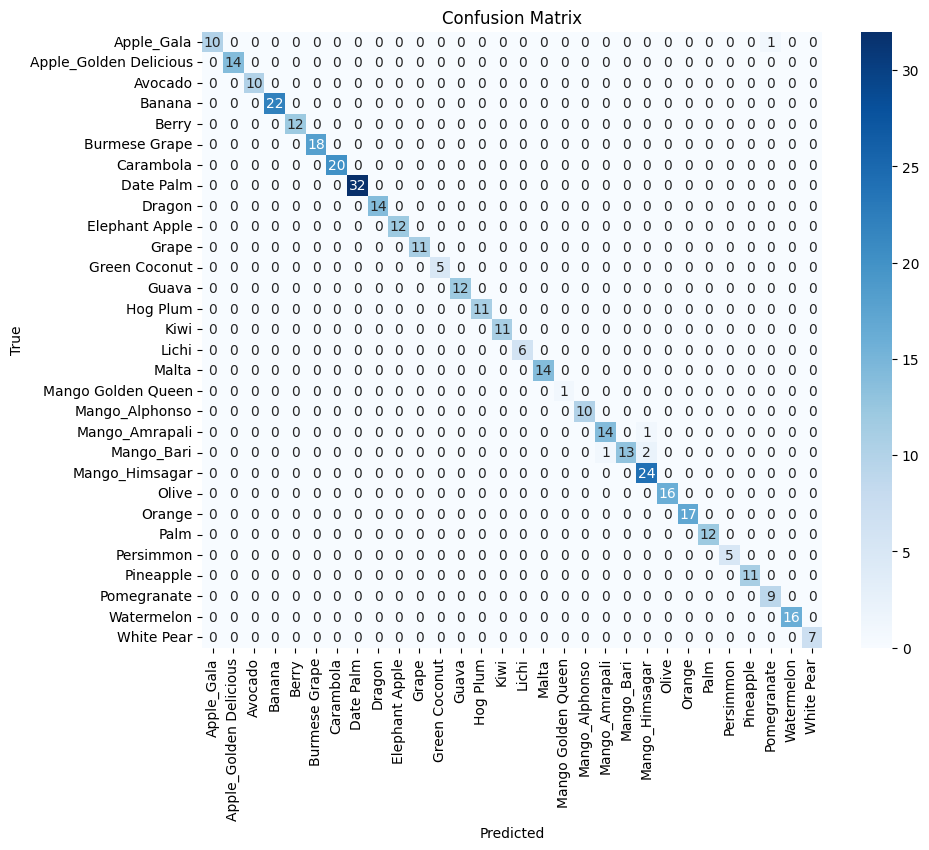


Classification Report:
                        precision    recall  f1-score   support

            Apple_Gala       1.00      0.91      0.95        11
Apple_Golden Delicious       1.00      1.00      1.00        14
               Avocado       1.00      1.00      1.00        10
                Banana       1.00      1.00      1.00        22
                 Berry       1.00      1.00      1.00        12
         Burmese Grape       1.00      1.00      1.00        18
             Carambola       1.00      1.00      1.00        20
             Date Palm       1.00      1.00      1.00        32
                Dragon       1.00      1.00      1.00        14
        Elephant Apple       1.00      1.00      1.00        12
                 Grape       1.00      1.00      1.00        11
         Green Coconut       1.00      1.00      1.00         5
                 Guava       1.00      1.00      1.00        12
              Hog Plum       1.00      1.00      1.00        11
               

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get all predictions and true labels
y_true = []
y_pred = []

final_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Class names (sorted to match index)
class_names = sorted(class_to_idx, key=class_to_idx.get)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Precision, recall, f1
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class names sorted to match model outputs
class_names = sorted(class_to_idx, key=class_to_idx.get)

# Get a few predictions
final_model.eval()

images, labels, preds = [], [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Store for display
        images.extend(inputs.cpu())
        labels.extend(targets)
        preds.extend(predicted.cpu())

        if len(images) >= 12:
            break


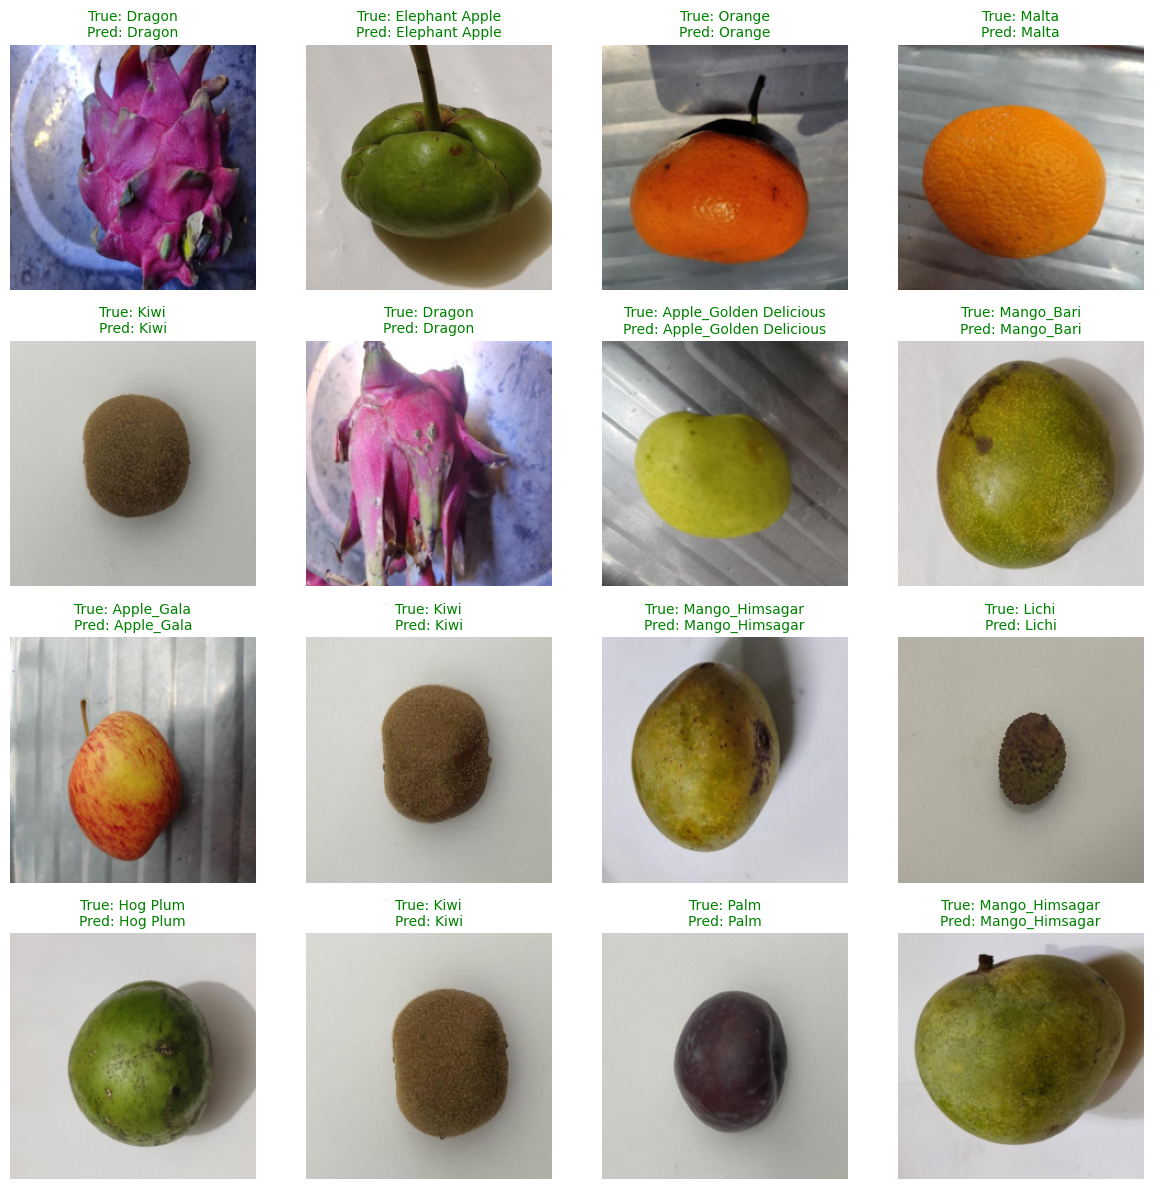

In [ ]:
def imshow(img_tensor):
    # Unnormalize image
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = imshow(images[i])
    true_label = class_names[labels[i]]
    pred_label = class_names[preds[i]]

    # Title: color green if correct, red if incorrect
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()


### Image Classification (with augumentation)

In this section, the same ResNet-50 architecture with ImageNet (IMAGENET1K_V1) pretrained weights was used, leveraging transfer learning to ensure efficient and accurate training for our dataset.To improve generalization and robustness, image augmentation during training is introduced. Initially applied a mild transformation using RandomRotation(20) and flip to simulate minor image variations. Then adopted to strategy, combining (RandomResizedCrop(224), to introduce scale and cropping variability; RandomHorizontalFlip(), RandomRotation(30) and ColorJitter for color-based variation. Other steps were repeated similar to classification.

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# No augmentation for test/val
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
train_dataset = FruitDataset(train_images, transform=train_transform)
test_dataset = FruitDataset(test_images, transform=test_transform)

In [ ]:
import random
from itertools import product

# Define search space
lr_options = [1e-4, 5e-4, 1e-3]
optimizers = ['adam', 'sgd', 'adamw']
batch_size = 32  # fixed for efficiency

# Get all combinations and randomly select 4
search_space = list(product(lr_options, optimizers))
random_trials = random.sample(search_space, k=4)


In [ ]:
def get_optimizer(name, model, lr):
    params = model.fc.parameters()
    if name == 'adam':
        return optim.Adam(params, lr=lr)
    elif name == 'sgd':
        return optim.SGD(params, lr=lr, momentum=0.9)
    elif name == 'adamw':
        return optim.AdamW(params, lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {name}")


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    train_acc_history = []
    val_acc_history = []

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f'Training complete in {(time.time() - since) // 60:.0f}m {(time.time() - since) % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, best_acc.item()


##Method

Again hyperparameter search was conducted after applying data augmentation to improve generalization. Based on earlier results where SGD underperformed, this time focused only on Adam and AdamW optimizers. The search space was slightly expanded with additional trials to explore better configurations. The best configuration was then selected for final retraining and evaluation.

In [ ]:
from torch.utils.data import random_split

results = []
num_epochs = 3

for lr, opt_name in random_trials:
    print(f"\n Trying: lr={lr}, optimizer={opt_name}")

    # Create new train/val split
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_sub, val_sub = random_split(train_dataset, [train_size, val_size])

    dataloaders = {
        'train': DataLoader(train_sub, batch_size=batch_size, shuffle=True, num_workers=2),
        'val': DataLoader(val_sub, batch_size=batch_size, shuffle=False, num_workers=2)
    }

    # Load ResNet50 and modify final layer
    model = models.resnet50(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, len(class_to_idx))
    model = model.to(device)

    # Set up optimizer & loss
    optimizer = get_optimizer(opt_name, model, lr)
    criterion = nn.CrossEntropyLoss()

    # Train and store results
    model, train_acc, val_acc, best_val_acc = train_model(model, dataloaders, criterion, optimizer, num_epochs)

    results.append({
        'lr': lr,
        'optimizer': opt_name,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'best_val_acc': best_val_acc
    })



 Trying: lr=0.0005, optimizer=adamw


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


Epoch 1/3
----------
train Loss: 2.8695 Acc: 0.2714
val Loss: 2.1279 Acc: 0.6063
Epoch 2/3
----------
train Loss: 1.8629 Acc: 0.6373
val Loss: 1.4145 Acc: 0.7714
Epoch 3/3
----------
train Loss: 1.2735 Acc: 0.8230
val Loss: 1.0852 Acc: 0.8444
Training complete in 3m 24s
Best val Acc: 0.8444

 Trying: lr=0.0001, optimizer=adamw
Epoch 1/3
----------
train Loss: 3.2886 Acc: 0.0794
val Loss: 3.0893 Acc: 0.2032
Epoch 2/3
----------
train Loss: 2.9678 Acc: 0.2603
val Loss: 2.7665 Acc: 0.3778
Epoch 3/3
----------
train Loss: 2.6899 Acc: 0.3762
val Loss: 2.5218 Acc: 0.5302
Training complete in 1m 6s
Best val Acc: 0.5302

 Trying: lr=0.001, optimizer=sgd
Epoch 1/3
----------
train Loss: 3.1906 Acc: 0.1397
val Loss: 2.8513 Acc: 0.4413
Epoch 2/3
----------
train Loss: 2.5589 Acc: 0.4563
val Loss: 2.2495 Acc: 0.5460
Epoch 3/3
----------
train Loss: 2.1119 Acc: 0.5841
val Loss: 1.8648 Acc: 0.6857
Training complete in 1m 6s
Best val Acc: 0.6857

 Trying: lr=0.0001, optimizer=adam
Epoch 1/3
---------

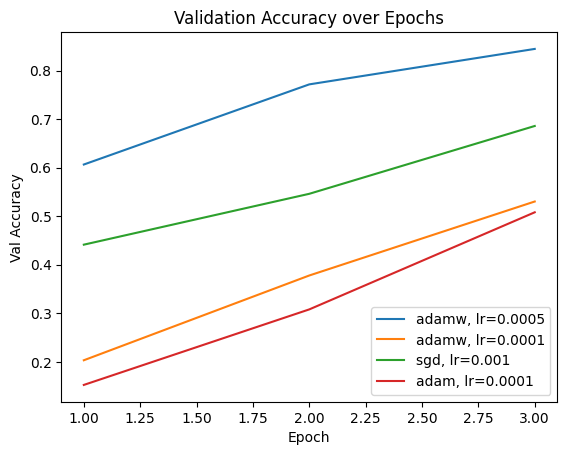


 Best Hyperparameters:
Optimizer: adamw
Learning rate: 0.0005
Best Val Accuracy: 0.8444


In [ ]:
import matplotlib.pyplot as plt

for i, r in enumerate(results):
    label = f"{r['optimizer']}, lr={r['lr']}"
    epochs = range(1, len(r['val_acc']) + 1)
    plt.plot(epochs, r['val_acc'], label=label)

plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend()
plt.show()

# Best result
best = max(results, key=lambda x: x['best_val_acc'])
print("\n Best Hyperparameters:")
print(f"Optimizer: {best['optimizer']}")
print(f"Learning rate: {best['lr']}")
print(f"Best Val Accuracy: {best['best_val_acc']:.4f}")


Epoch 1/8
----------
train Loss: 2.8285 Acc: 0.3151
val Loss: 2.1328 Acc: 0.6063
Epoch 2/8
----------
train Loss: 1.8261 Acc: 0.6698
val Loss: 1.4572 Acc: 0.7524
Epoch 3/8
----------
train Loss: 1.2909 Acc: 0.7865
val Loss: 1.1409 Acc: 0.8127
Epoch 4/8
----------
train Loss: 1.0060 Acc: 0.8437
val Loss: 0.8474 Acc: 0.8508
Epoch 5/8
----------
train Loss: 0.8647 Acc: 0.8651
val Loss: 0.7667 Acc: 0.8730
Epoch 6/8
----------
train Loss: 0.7103 Acc: 0.8865
val Loss: 0.6266 Acc: 0.8698
Epoch 7/8
----------
train Loss: 0.6058 Acc: 0.9087
val Loss: 0.5835 Acc: 0.8857
Epoch 8/8
----------
train Loss: 0.6078 Acc: 0.8849
val Loss: 0.5712 Acc: 0.9016
Training complete in 3m 14s
Best val Acc: 0.9016


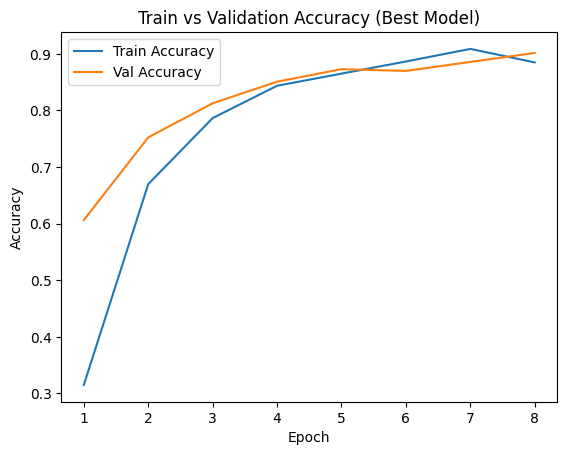

In [ ]:
# this section is only for tracking
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_sub, val_sub = random_split(train_dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_sub, batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(val_sub, batch_size=32, shuffle=False, num_workers=2)
}

# Reload model
model = models.resnet50(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, len(class_to_idx))
model = model.to(device)

# Optimizer & Loss
optimizer = get_optimizer(best['optimizer'], model, best['lr'])
criterion = nn.CrossEntropyLoss()

# Train & track accuracy
model, train_acc, val_acc, _ = train_model(model, dataloaders, criterion, optimizer, num_epochs=8)

# Plot curve
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy (Best Model)")
plt.legend()
plt.show()


In [ ]:
# Recreate dataloader with full training set
final_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Load fresh model
final_model = models.resnet50(weights="IMAGENET1K_V1")
for param in final_model.parameters():
    param.requires_grad = False
final_model.fc = nn.Linear(final_model.fc.in_features, len(class_to_idx))
final_model = final_model.to(device)

# Optimizer and loss (best params)
final_optimizer = get_optimizer(best['optimizer'], final_model, best['lr'])
final_criterion = nn.CrossEntropyLoss()

# Retrain using full training data
final_model, _, _, _ = train_model(
    final_model,
    dataloaders={'train': final_train_loader, 'val': final_train_loader},
    criterion=final_criterion,
    optimizer=final_optimizer,
    num_epochs=8
)


Epoch 1/8
----------
train Loss: 2.6809 Acc: 0.3651
val Loss: 1.8763 Acc: 0.6521
Epoch 2/8
----------
train Loss: 1.6070 Acc: 0.7016
val Loss: 1.1801 Acc: 0.8203
Epoch 3/8
----------
train Loss: 1.1413 Acc: 0.8006
val Loss: 0.8798 Acc: 0.8483
Epoch 4/8
----------
train Loss: 0.8631 Acc: 0.8476
val Loss: 0.7268 Acc: 0.8787
Epoch 5/8
----------
train Loss: 0.7362 Acc: 0.8546
val Loss: 0.5967 Acc: 0.8959
Epoch 6/8
----------
train Loss: 0.6212 Acc: 0.8889
val Loss: 0.5144 Acc: 0.9060
Epoch 7/8
----------
train Loss: 0.5437 Acc: 0.9060
val Loss: 0.4650 Acc: 0.9098
Epoch 8/8
----------
train Loss: 0.5049 Acc: 0.9035
val Loss: 0.4234 Acc: 0.9194
Training complete in 5m 49s
Best val Acc: 0.9194


# Evaluation and Results

After initially retraining the augmented classification model for 5 epochs, the performance was good but still below that of the non-augmented model. To address this, the training duration was extended to 8 epochs. This increase led to a noticeable improvement, with the final test accuracy reaching 91.6%. However, it remained slightly lower than the test accuracy achieved by the non-augmented model.From the val/accuracy curves we could see that by epoch 5 onward, both curves begin to converge and validation accuracy improves up to training performance. This indicates that the model is learning to generalize despite the increased data variability.

High performing ones included common varieties such as Banana, Pineapple, Berry and Carambola all with good scores across all metrics. These classes likely had more training samples and distinctive visual features.However, classes such as Hog Plum (F1-score: 0.41), Mango_Himsagar (0.77), Olive (0.55) and Pomegranate (0.88) showed reduced performance. This drop suggests that these categories may be more sensitive to augmentation induced distortion or suffer from class imbalance which may have made it difficult to converge on minority classes in 8 epochs.

While accuracy slightly dropped, the augmented model is better suited. It may underperform on clean test images but is expected to generalize better to noisy or unseen data (for eg., rotated or shadowed fruits).However, it’s likely that training the augmented dataset for more epochs (eg., 10–20) could improve generalization further, as augmented data typically requires longer training to converge due to more variability.


In [ ]:
# test_loader before evaluation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Evaluate final model on test set
final_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\n Final Test Accuracy: {100 * correct / total:.2f}%")



 Final Test Accuracy: 91.62%


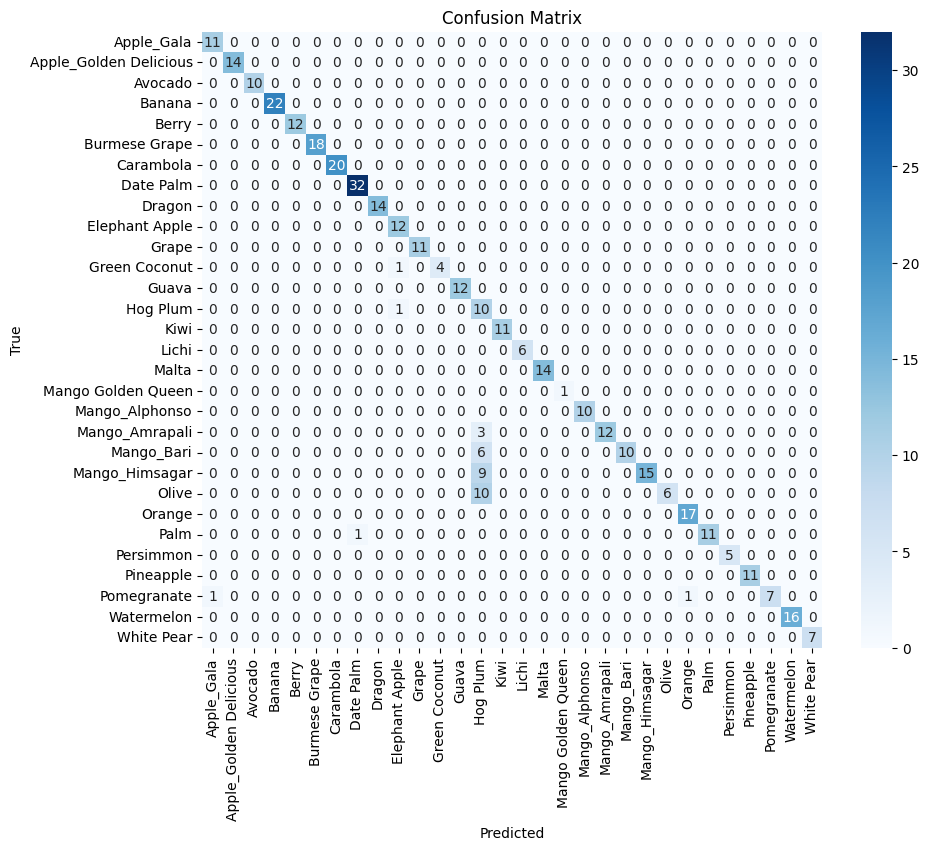


Classification Report:
                        precision    recall  f1-score   support

            Apple_Gala       0.92      1.00      0.96        11
Apple_Golden Delicious       1.00      1.00      1.00        14
               Avocado       1.00      1.00      1.00        10
                Banana       1.00      1.00      1.00        22
                 Berry       1.00      1.00      1.00        12
         Burmese Grape       1.00      1.00      1.00        18
             Carambola       1.00      1.00      1.00        20
             Date Palm       0.97      1.00      0.98        32
                Dragon       1.00      1.00      1.00        14
        Elephant Apple       0.86      1.00      0.92        12
                 Grape       1.00      1.00      1.00        11
         Green Coconut       1.00      0.80      0.89         5
                 Guava       1.00      1.00      1.00        12
              Hog Plum       0.26      0.91      0.41        11
               

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get all predictions and true labels
y_true = []
y_pred = []

final_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Class names (sorted to match index)
class_names = sorted(class_to_idx, key=class_to_idx.get)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Precision, recall, f1
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class names sorted to match model outputs
class_names = sorted(class_to_idx, key=class_to_idx.get)

# Get a few predictions
final_model.eval()

images, labels, preds = [], [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Store for display
        images.extend(inputs.cpu())
        labels.extend(targets)
        preds.extend(predicted.cpu())

        if len(images) >= 12:
            break


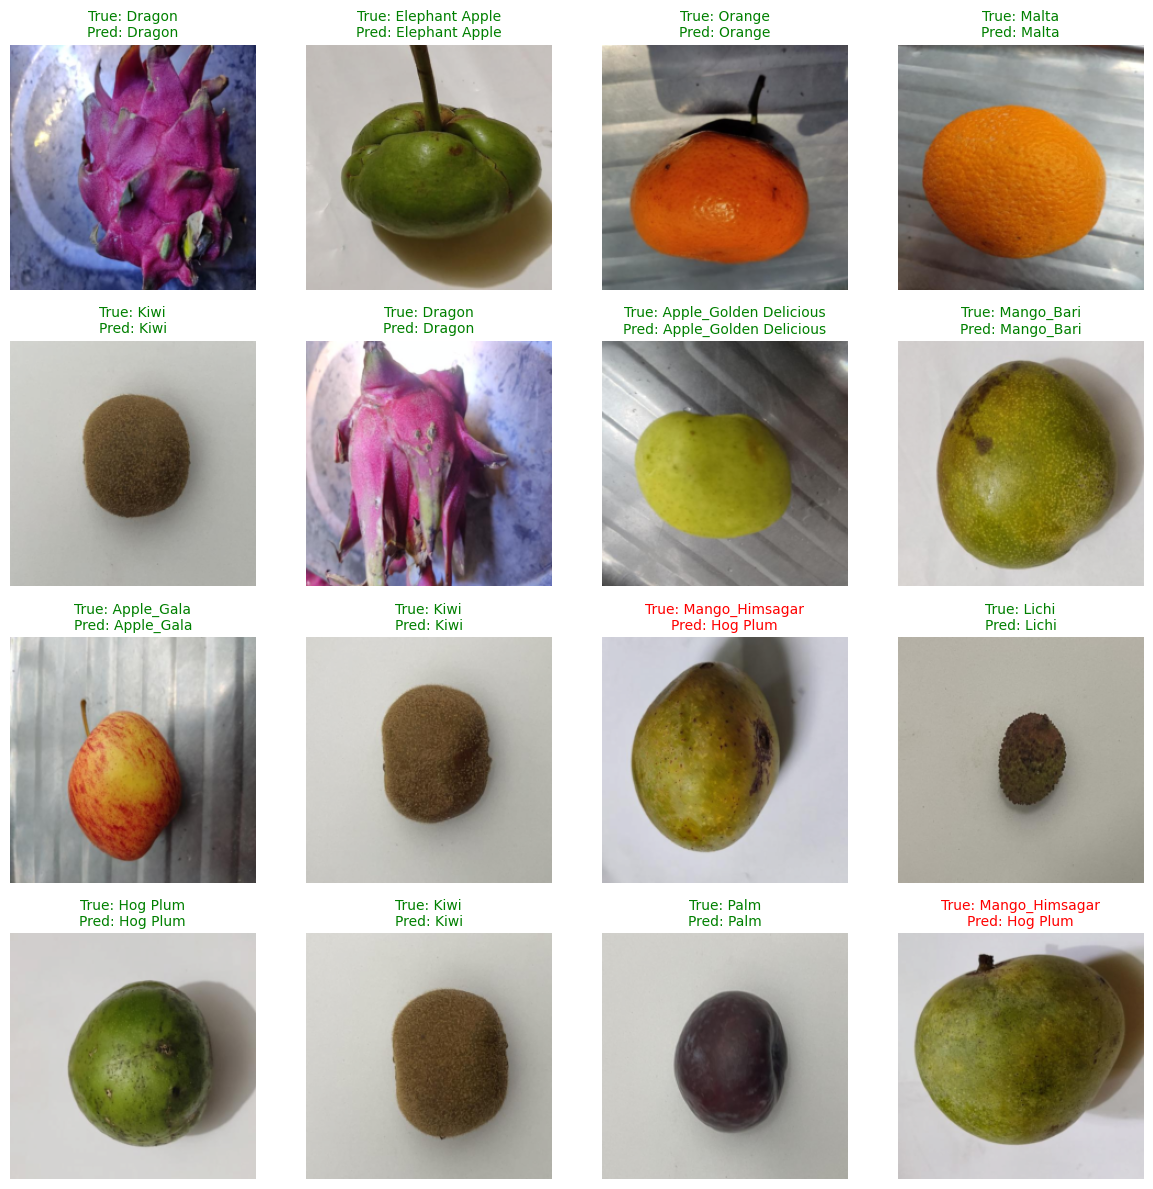

In [ ]:
def imshow(img_tensor):
    # Unnormalize image
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = imshow(images[i])
    true_label = class_names[labels[i]]
    pred_label = class_names[preds[i]]

    # Title: color green if correct, red if incorrect
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()


### Image Segmentation

For the image segmentation task, the same FruitSeg30 dataset was used, which includes corresponding mask images for each fruit image stored in separate directories. A custom PyTorch Dataset class (FruitSegmentationDatasetBinary) was implemented to dynamically pair each input image with its corresponding binary segmentation mask, resizing both to 512×512 pixels and converting them to tensors.

The segmentation model architecture was based on as before, ResNet-50, using the convolutional layers from a pretrained model (weights="IMAGENET1K_V1") as an encoder backbone. The final segmentation head consisted of convolutional layers and a bilinear upsampling layer to generate segmentation outputs of the original resolution. The model predicts a single-channel binary mask, trained using binary cross-entropy with logits (BCEWithLogitsLoss) and evaluated using Dice score and Jaccard Index (IoU).

**Dataset preparation:**

In the dataset, each fruit variety has two subfolders (Images, contains RGB fruit images and Mask that contains the corresponding binary segmentation masks). However, the masks are not stored as a separate paired list, instead, they were saved using a consistent naming convention. For example, Image: Images/58.jpg and Mask: Mask/58_mask.png or 58_mask.jpg. Hence to efficiently pair each image with its corresponding mask, implemented dynamic path construction inside the custom PyTorch Dataset class and allowed to programmatically locate the corresponding mask for each image.

This improved flexibility and scalability when working with multiple fruit varieties stored in different folders. It also helps avoid errors from hardcoding file paths and simplifies our preprocessing.

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split

## Custom dataset for segmentation
class FruitSegmentationDatasetBinary(Dataset):
    def __init__(self, image_paths, transform=None, target_size=(512, 512)):
        self.image_paths = image_paths
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        # Extract filename
        image_filename = os.path.basename(image_path)
        image_base_name = os.path.splitext(image_filename)[0]

        # Get path to mask
        image_dir = os.path.dirname(image_path)
        mask_dir = image_dir.replace('/Images', '/Mask')

        mask_path_png = os.path.join(mask_dir, f"{image_base_name}_mask.png")
        mask_path_jpg = os.path.join(mask_dir, f"{image_base_name}_mask.jpg")

        mask_path = None
        if os.path.exists(mask_path_png):
            mask_path = mask_path_png
        elif os.path.exists(mask_path_jpg):
            mask_path = mask_path_jpg
        else:
            raise FileNotFoundError(f"Mask not found for image: {image_path}")

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Resize both
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        # Convert to tensor
        image = transforms.ToTensor()(image)
        mask = torch.tensor(np.array(mask) > 0, dtype=torch.float32).unsqueeze(0)

        return image, mask


In [ ]:
#Folder Setup and Dataset Split
# Base path to dataset
fruitseg_dir = '/content/drive/MyDrive/assign2_6165/FruitSeg30/FruitSeg30'

# Build list of image paths
image_paths = []
fruit_varieties = [v for v in os.listdir(fruitseg_dir) if os.path.isdir(os.path.join(fruitseg_dir, v))]

for variety in fruit_varieties:
    images_dir = os.path.join(fruitseg_dir, variety, 'Images')
    if not os.path.exists(images_dir):
        continue
    for img_name in os.listdir(images_dir):
        image_paths.append(os.path.join(images_dir, img_name))


##Method

A random hyperparameter search will be performed with 4 trial configurations, sampling from combinations of learning rates [1e-3, 1e-4], batch sizes [8, 16], and optimizers ['adam', 'adamw']. Once the best configuration is identified, the model will be retrained.

All input images and corresponding binary masks were resized to 512×512, due to two main factors, consistency and model design. Although most images in the dataset were already 512×512, a few varieties as mentioned earlier had very high-resolution images (e.g., 4000×3000). Resizing ensured uniform input size across the dataset, which is critical for efficient batch processing and model training. Also, the output of the segmentation head in our ResNet-50 architecture was upsampled to 512×512, so having inputs of the same size helped maintain alignment between predictions and ground-truth masks during loss computation.This will again restore the spatial dimensions of the output mask to match the input size, allowing us to directly compare the predicted mask and ground truth mask during training and evaluation phase.

However, the larger image size also adds computational trade-off. Compared to image classification (where we used 224×224 inputs), segmentation images are larger in pixel area. This increased memory usage per sample. As a result, adopted smaller batch sizes (8 and 16) during training to avoid out of memory errors and to allow stable gradient updates. While smaller batch sizes can introduce more noise in training, they were chosen to accommodate the memory intensive nature of segmentation with larger inputs and high-dimensional feature maps of ResNet-50.


In [ ]:
# Split image paths into train/test
train_image_paths, test_image_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Create datasets
train_dataset = FruitSegmentationDatasetBinary(train_image_paths)
test_dataset = FruitSegmentationDatasetBinary(test_image_paths)

# Final test_loader will be used after retraining best model


In [ ]:
# all helper Functions: Dice, Optimizer, Trainer
import torch.nn as nn
import torchvision.models as models
import time


# Dice Score Calculation
def calculate_dice_score(predictions, targets, threshold=0.5):
    predictions = predictions > threshold
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum()
    dice_score = 2. * intersection / (union + intersection)
    return dice_score.item()


# Segmentation Model
class ResNetSegmentation(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNetSegmentation, self).__init__()
        base_model = models.resnet50(weights="IMAGENET1K_V1")
        self.encoder = nn.Sequential(*list(base_model.children())[:-2])
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, num_classes, kernel_size=1),
            nn.Upsample(size=(512, 512), mode="bilinear", align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.segmentation_head(x)
        return x

# Get Optimizer
def get_optimizer(model, opt_name, lr):
    if opt_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=lr)
    elif opt_name == 'adamw':
        return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    else:
        raise ValueError(f"Unsupported optimizer: {opt_name}")

# Train Function
def train_segmentation_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3):
    train_losses = []
    val_dices = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        # Average training loss for this epoch
        avg_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        # Validation
        val_loss, val_dice = evaluate_model(model, val_loader, criterion)
        val_dices.append(val_dice)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss:.4f}, Val Dice: {val_dice:.4f}")

    return train_losses, val_dices


In [ ]:
#evaluation function
def evaluate_model(model, loader, criterion):
    model.eval()
    dice_scores = []
    iou_scores = []
    running_loss = 0.0
    with torch.no_grad():
        for inputs, masks in loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = torch.sigmoid(model(inputs))
            loss = criterion(outputs, masks)
            running_loss += loss.item() * inputs.size(0)
            dice = calculate_dice_score(outputs, masks)
            iou = calculate_iou_score(outputs, masks)
            dice_scores.append(dice)
            iou_scores.append(iou)
    avg_dice = torch.tensor(dice_scores).mean().item()
    avg_loss = running_loss / len(loader.dataset)
    avg_iou = torch.tensor(iou_scores).mean().item()
    return avg_loss, avg_dice, avg_iou


In [ ]:
from torch.utils.data import random_split, DataLoader
import random
from itertools import product


# Hyperparameter Search Space
lrs = [1e-3, 1e-4]
batch_sizes = [8, 16]
optimizers = ['adam', 'adamw']
search_space = list(product(lrs, batch_sizes, optimizers))
random_trials = random.sample(search_space, k=4)


# Dataset Split (train/val)
train_len = int(0.8 * len(train_image_paths))
val_len = len(train_image_paths) - train_len
train_subset, val_subset = random_split(train_image_paths, [train_len, val_len])

# Run Each Trial
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()

for lr, bs, opt_name in random_trials:
    print(f"\n Trial: LR={lr}, Batch={bs}, Optimizer={opt_name}")

    train_ds = FruitSegmentationDatasetBinary(train_subset)
    val_ds = FruitSegmentationDatasetBinary(val_subset)
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=2, pin_memory=True)

    model = ResNetSegmentation().to(device)
    optimizer = get_optimizer(model, opt_name, lr)

    train_segmentation_model(model, train_loader, criterion, optimizer, num_epochs=3)
    val_loss, val_dice = evaluate_model(model, val_loader, criterion)

    print(f"Validation Dice: {val_dice:.4f}")
    results.append({
        'model': model,
        'lr': lr,
        'batch_size': bs,
        'optimizer': opt_name,
        'val_dice': val_dice,
        'val_loss': val_loss
    })



 Trial: LR=0.001, Batch=16, Optimizer=adamw
Epoch 1/3 - Loss: 0.3265
Epoch 2/3 - Loss: 0.0957
Epoch 3/3 - Loss: 0.0787
Validation Dice: 0.6484

 Trial: LR=0.001, Batch=8, Optimizer=adam
Epoch 1/3 - Loss: 0.2576
Epoch 2/3 - Loss: 0.1047
Epoch 3/3 - Loss: 0.0934
Validation Dice: 0.6491

 Trial: LR=0.0001, Batch=8, Optimizer=adamw
Epoch 1/3 - Loss: 0.1096
Epoch 2/3 - Loss: 0.0623
Epoch 3/3 - Loss: 0.0475
Validation Dice: 0.6528

 Trial: LR=0.0001, Batch=16, Optimizer=adamw
Epoch 1/3 - Loss: 0.1680
Epoch 2/3 - Loss: 0.0632
Epoch 3/3 - Loss: 0.0528
Validation Dice: 0.6517


In [ ]:
best_result = max(results, key=lambda x: x['val_dice'])


In [ ]:
from torch.utils.data import random_split, DataLoader

# block for curve tracking
train_len = int(0.8 * len(train_image_paths))
val_len = len(train_image_paths) - train_len

train_subset, val_subset = random_split(train_image_paths, [train_len, val_len])

train_dataset = FruitSegmentationDatasetBinary(train_subset)
val_dataset = FruitSegmentationDatasetBinary(val_subset)

train_loader = DataLoader(train_dataset, batch_size=best_result['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=best_result['batch_size'], shuffle=False, num_workers=2)


In [ ]:
final_model = ResNetSegmentation().to(device)
final_optimizer = get_optimizer(final_model, best_result['optimizer'], best_result['lr'])
criterion = nn.BCEWithLogitsLoss()

print("\nRetraining best model based on parameter search...")
train_losses, val_dices = train_segmentation_model(
    final_model, train_loader, val_loader,
    criterion, final_optimizer, num_epochs=5
)


Retraining best model based on parameter search...
Epoch 1/5 - Train Loss: 0.1078, Val Dice: 0.6480
Epoch 2/5 - Train Loss: 0.0575, Val Dice: 0.6496
Epoch 3/5 - Train Loss: 0.0504, Val Dice: 0.6522
Epoch 4/5 - Train Loss: 0.0448, Val Dice: 0.6522
Epoch 5/5 - Train Loss: 0.0376, Val Dice: 0.6531


In [ ]:
# Re-creating test set
test_dataset = FruitSegmentationDatasetBinary(test_image_paths)
test_loader = DataLoader(test_dataset,
                         batch_size=best_result['batch_size'],
                         shuffle=False, num_workers=2)

# Evaluate
print("\n Final Evaluation on Test Set:")
test_loss, test_dice = evaluate_model(final_model, test_loader, criterion)
print(f"Final Test Dice Score: {test_dice:.4f}")



 Final Evaluation on Test Set:
Final Test Dice Score: 0.6531


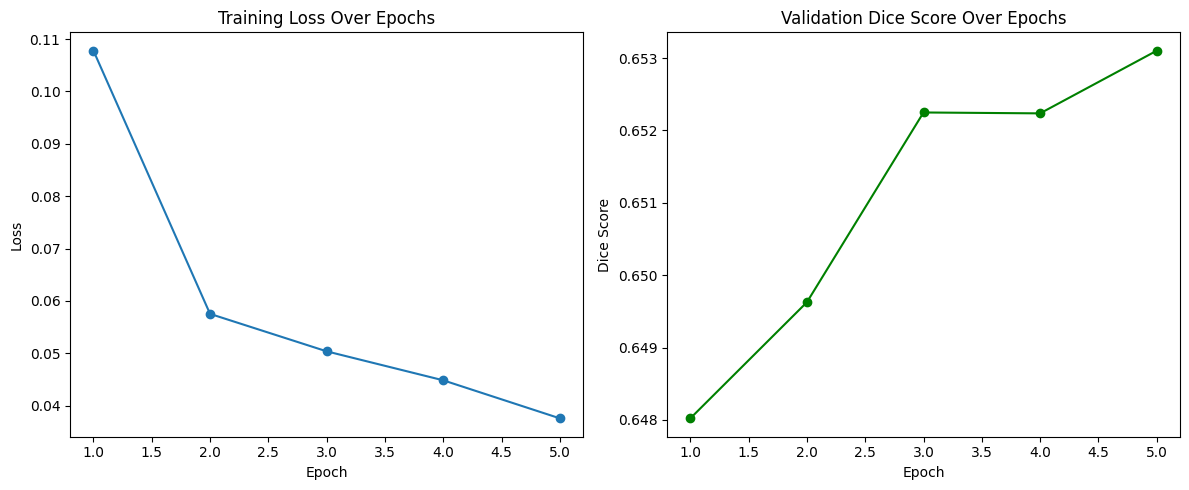

In [ ]:
import matplotlib.pyplot as plt

def plot_segmentation_curves(train_losses, val_dices):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o')
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Plot Validation Dice
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_dices, marker='o', color='green')
    plt.title("Validation Dice Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")

    plt.tight_layout()
    plt.show()

plot_segmentation_curves(train_losses, val_dices)


##Evaluation and Results

After the hyperparameter search, the the best model configuration was identified as Learning Rate: 0.0001, Batch Size: 8, Optimizer: AdamW and the best Validation Dice Score: 0.6528. This model was then retrained on the full training split (with 5 epochs), and evaluated on the test set. The final results are Test dice score- 0.6531, Test IoU- 0.9419.The training loss consistently decreased across epochs, and the validation Dice gradually improved, stabilizing at 0.6531. Dice score indicates moderate segmentation accuracy. While the IoU score is quite high at 0.94, it may be likely influenced by class imbalance in the fruit varieties and the mask images being dominated by background pixels.The segmentation task was binary (fruit vs background) as the masks were grayscale (0 for background, 255 for fruit). This could likely reflect in the dice score as measure of segmentation quality. The IoU score being higher might reflect the background heavy nature.

Though the dice score indicates moderate performance, the predicted masks aligned well with the true fruit regions in most test images. The model effectively identified the general shape and location of fruits, even though it struggled with precisely outlining the boundaries which we could see in the visualisations.Some of the factors could be

a) Limited training epochs, extending the hyperparameter search trials and training time could help improve Dice score further.
b)Unlike classification, no data augmentation was applied, augmenting masks and images together (e.g., flipping, rotating) can improve generalization. c) While images and masks were resized to 512×512, we could try to downscale images (for instance, to 256×256), and use larger batch sizes instead of batch sizes to 8 or 16 enabling stable training.
d)Also, some of the masks in the dataset contained large regions of background ( non-fruit pixels), with the actual fruit occupying a  small portion of the image, this could have created some imbalance.




In [ ]:
def calculate_iou_score(predictions, targets, threshold=0.5):
    # Binarize predictions
    predictions = predictions > threshold
    targets = targets > threshold  # Just to be safe

    # Convert to boolean for bitwise operations
    predictions = predictions.bool()
    targets = targets.bool()

    # Intersection and union
    intersection = (predictions & targets).float().sum()
    union = (predictions | targets).float().sum()

    if union == 0:
        return 1.0
    return (intersection / union).item()


_, _, test_iou = evaluate_model(final_model, test_loader, criterion)
print(f"Final Test IoU (Jaccard) Score: {test_iou:.4f}")

Final Test IoU (Jaccard) Score: 0.9419


In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, num_samples=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(15, num_samples * 3))
    for i, idx in enumerate(indices):
        image, true_mask = dataset[idx]
        with torch.no_grad():
            pred_mask = model(image.unsqueeze(0).to(device))
            pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().numpy()
            pred_mask = (pred_mask > 0.5).astype(float)

        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Original Image")
        plt.axis('off')

        # Ground Truth
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


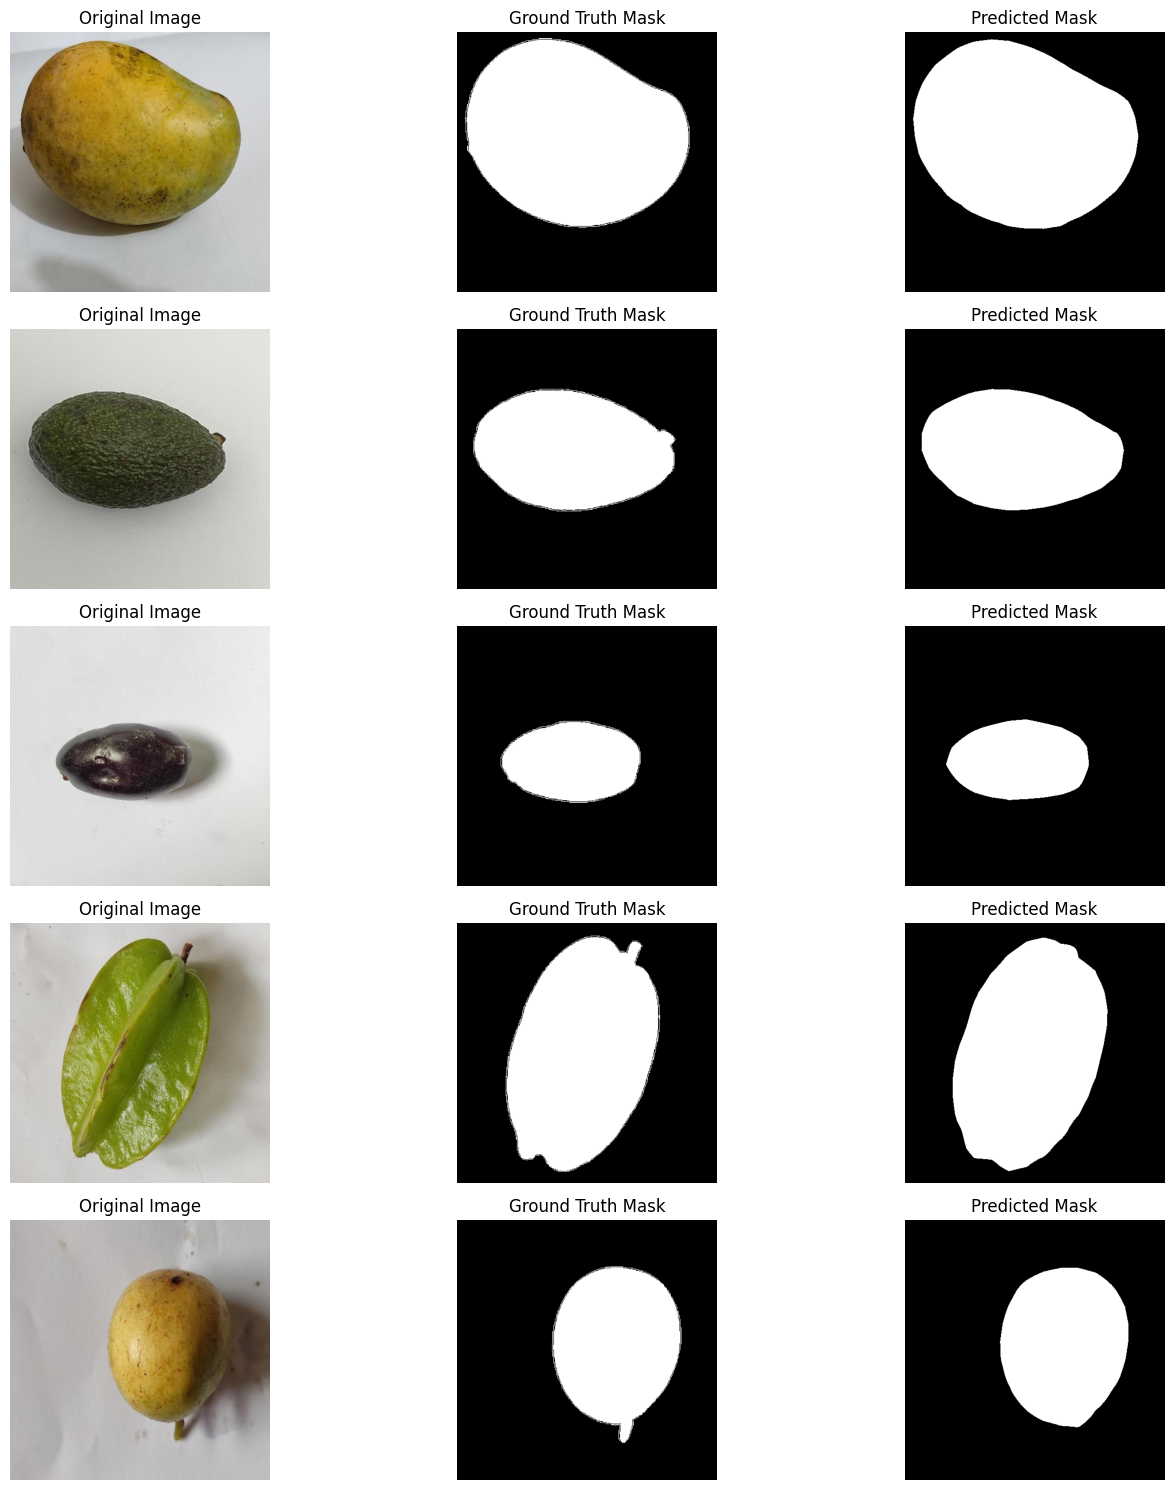

In [ ]:
visualize_predictions(final_model, test_dataset, num_samples=5)


##Conclusion
We have done two core tasks, image classification and image segmentation.Image classification models performed with high accuracy. In the segmentation task, the best-performing model reached a Dice score of 0.6531 and an IoU score of 0.9419. Although the Dice score appears modest, visual evaluation of the predicted masks revealed good alignment with the ground truth, but fine boundary details, remain an area for improvement. Overall, the models demonstrated strong capabilities in classifying and segmenting fruits, and the experiments laid a solid foundation for further development.

Additionally, for better model results we could increase training duration to 10–20 epochs or introduce learning rate schedulers. While ResNet-50 were used effectively as base, we could explore architectures such as U-Net for improved boundary precision. Importantly, we could balance class representation through oversampling or synthetic data generation which could essentially enhance performance.



##References

1) Shamrat, F. J. M., Shakil, R., Idris, M. Y. I., Akter, B., & Zhou, X. (2024). FruitSeg30_Segmentation dataset & mask annotations: A novel dataset for diverse fruit segmentation and classification. Data in Brief, 56, 110821.https://www.sciencedirect.com/science/article/pii/S2352340924007856



2) University of Southern Queensland. (n.d.). FruitSeg30 segmentation dataset mask annotations: A novel dataset for diverse fruit segmentation and classification. University of Southern Queensland. https://research.usq.edu.au/item/z9y80/fruitseg30-segmentation-dataset-mask-annotations-a-novel-dataset-for-diverse-fruit-segmentation-and-classification


3) https://pytorch.org/docs/stable/index.html



##Dataset

Dataset can be downloaded from:

Shamrat, F M Javed Mehedi; Shakil, Rashiduzzaman ; Idris, Mohd Yamani Idna ; Akter, Bonna; Zhou, Xujuan  (2024), “FruitSeg30_Segmentation Dataset & Mask Annotations”, Mendeley Data, V3, doi: 10.17632/vkht8pfsp3.https://data.mendeley.com/datasets/vkht8pfsp3/3